In [1]:
library(tidyverse)
library(universalmotif)
#library(MotifDb)
library(cowplot)

# # Assuming 'your_output.meme' is the output MEME file from xstreme
# motifs_from_xstreme <- read_meme('/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/zm_dir/mesophyll/xstreme/combined.meme')

# # If you only want a subset of the motifs, you can subset them. 
# # Here we'll use all of them for demonstration:
#motifs <- convert_motifs(motifs_from_xstreme)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2          ✔ readr     2.1.4     
✔ forcats   1.0.0.9000     ✔ stringr   1.5.1     
✔ ggplot2   3.4.4          ✔ tibble    3.2.1     
✔ lubridate 1.9.2          ✔ tidyr     1.3.0     
✔ purrr     1.0.2          
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
# quantile(zm_meso_test$EVALUE, na.rm = TRUE)

In [3]:
filter_motifs <- function(tsv_file, meme_file, species, cell_type) {
  
  # Step 1: Filter TSV file
  tsv_data <- read_tsv(tsv_file, show_col_types = FALSE) %>%
    #filter(SIM_SOURCE == "00.data/conserved_consensus_motifs_Fig2B.meme") %>% 
    #filter(SOURCE == "MEME") %>% 
    mutate(streme_alt_id = str_c(ID,ALT_ID, sep = "-"))# %>% 
    #dplyr::filter(EVALUE < .03)
  
  # Step 2: Read MEME file
  motifs_list <- read_meme(meme_file)
  
  filtered_motifs_list <- lapply(motifs_list, function(motif) {
    if(motif@altname %in% tsv_data$streme_alt_id) {
      motif_family <- filter(tsv_data, streme_alt_id == motif@altname)$SIM_MOTIF
      motif@family <- as.character(motif_family)
      motif@organism <- species

      # Add the "species" and "cell_type" to the altname field
      motif@altname <- paste(motif@altname, species, cell_type, sep = "_")

      motif <- trim_motifs(motif)
      motif <- round_motif(motif, pct.tolerance = .1)
      return(motif)
    } else {
      return(motif)
    }
  })
  
  # Filter out motifs with a homopolymer (e.g., "AAAAA")
  # Extract the consensus sequences from each motif
  consensus_sequences <- sapply(filtered_motifs_list, function(x) if (!is.null(x)) x@consensus else NULL)

  # Search for motifs that have the pattern of five identical nucleotides
  has_homopolymer <- grepl("(A{6,}|T{5,}|C{5,}|G{8,}|TATATA|YYYYT|TTTTY|TYTYT|YTYTYT)", consensus_sequences)

  # Exclude the motifs with the homopolymer pattern
  filtered_motifs_list <- filtered_motifs_list[!has_homopolymer]
  
  tsv_data <- tsv_data %>% 
      mutate(ID = paste(ID, species, cell_type, sep = "_"))
    
  return(list(tsv_data = tsv_data, motifs = filtered_motifs_list))
}

                                

In [4]:
base_path <- "/scratch/jpm73279/comparative_single_cell/07.call.ACRs/11.contrasting_bs_ms/"

file_list <- list(
  Os = list(
    meme = paste0(base_path, "os_fimo_output_ms_vs_bs/xstreme/combined.meme"),
    tsv = paste0(base_path, "os_fimo_output_ms_vs_bs/xstreme/xstreme.tsv")
  ),
  Zm = list(
    meme = paste0(base_path, "zm_fimo_output_ms_vs_bs/xstreme/combined.meme"),
    tsv = paste0(base_path, "zm_fimo_output_ms_vs_bs/xstreme/xstreme.tsv")
  ),
  Uf = list(
    meme = paste0(base_path, "uf_fimo_output_ms_vs_bs/xstreme/combined.meme"),
    tsv = paste0(base_path, "uf_fimo_output_ms_vs_bs/xstreme/xstreme.tsv")
  ),
  Pm = list(
    meme = paste0(base_path, "pm_fimo_output_ms_vs_bs/xstreme/combined.meme"),
    tsv = paste0(base_path, "pm_fimo_output_ms_vs_bs/xstreme/xstreme.tsv")
  ),
  Sb = list(
    meme = paste0(base_path, "sb_fimo_output_ms_vs_bs/xstreme/combined.meme"),
    tsv = paste0(base_path, "sb_fimo_output_ms_vs_bs/xstreme/xstreme.tsv")
  )
)

# Now, let's apply the filter_motifs function to each species' set of files:

all_filtered_motifs <- list()

for(species in names(file_list)) {
  result <- filter_motifs(file_list[[species]]$tsv, file_list[[species]]$meme, species, "mesophyll")
  all_filtered_motifs[[species]] <- result$motifs
}

# Remove NULL entries from the list of lists
all_filtered_motifs <- lapply(all_filtered_motifs, function(species_motifs) {
  Filter(Negate(is.null), species_motifs)
})

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


In [5]:

process_motif_sublist <- function(sublist) {
    # Apply merge_similar to the sublist of motifs
    merged_motifs <- merge_similar(sublist, 
                        threshold = 0.8,
                        #min.position.ic = .9,
                        tryRC = TRUE)
    return(merged_motifs)
}



update_motif_altname <- function(motif_list) {
    # Iterate over the list of motifs using their names
    for (motif_name in names(motif_list)) {
        # Append the list index (motif_name) to the @altname slot of each motif
        motif_list[[motif_name]]@altname <- paste(motif_list[[motif_name]]@altname, motif_name, sep = "_")
    }
    return(motif_list)
}


# Apply the function to each sublist in your main list
all_filtered_motifs <- lapply(all_filtered_motifs, process_motif_sublist)
merged_list <- unlist(all_filtered_motifs, recursive = FALSE)
merged_list <- update_motif_altname(merged_list)

In [6]:
filtered_motifs <- lapply(merged_list, function(motif) {
  motif@name <- motif@altname
  return(motif)
})


In [7]:
# Generate the motif tree
tree <- motif_tree(filtered_motifs, layout = "rectangular", linecol = "organism",
                  method = "HELL")


Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun



In [8]:
# Extract the order based on the tree
new.order <- tree$data$label[tree$data$isTip]
new.order <- rev(new.order[order(tree$data$y[tree$data$isTip])])


In [9]:
# Extract names or altname from filtered_motifs
motif_names <- sapply(filtered_motifs, function(x) x@name)

# Match the names with the new_order
order_index <- match(new.order, motif_names)

# Reorder filtered_motifs based on the matched index
reordered_motifs <- filtered_motifs[order_index]


In [10]:
#filtered_motifs <- filtered_motifs[new.order]

In [11]:
options(repr.plot.width=30, repr.plot.height=70)

# Plot the motifs and the tree side by side
ms_specific_tree <- plot_grid(nrow = 1, rel_widths = c(1, -0.15, 1),
          tree + xlab(""), NULL,
          view_motifs(reordered_motifs) +
            ylab(element_blank()) +
            theme(
              axis.line.y = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.y = element_blank(),
              axis.text = element_text(colour = "white")
            )
)

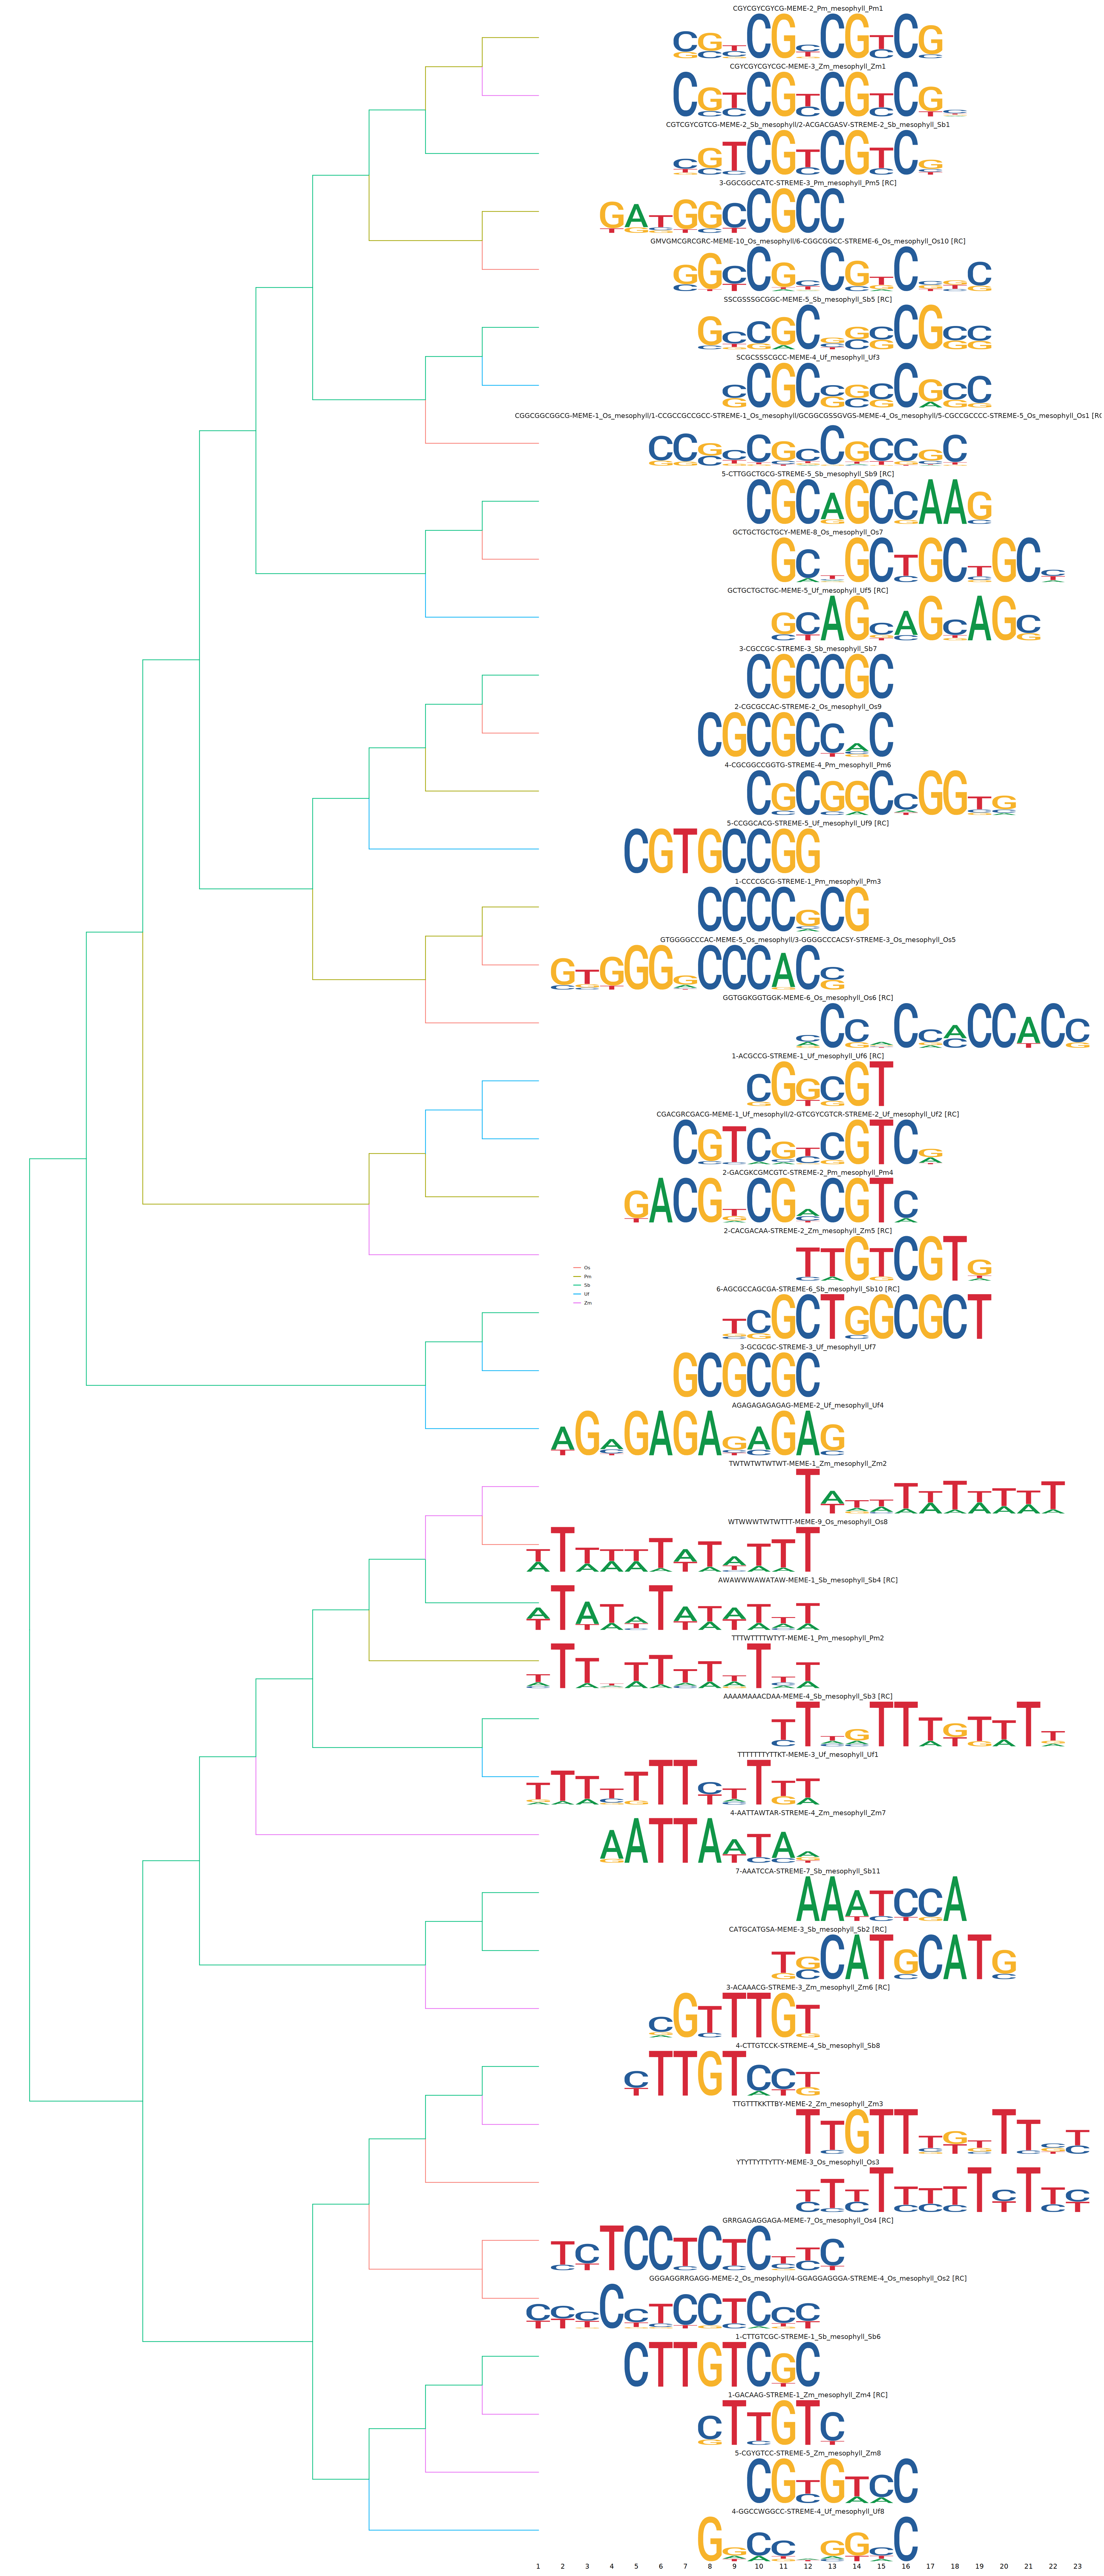

In [12]:
ms_specific_tree

In [13]:
base_path <- "/scratch/jpm73279/comparative_single_cell/07.call.ACRs/11.contrasting_bs_ms/"

file_list <- list(
  Os = list(
    meme = paste0(base_path, "os_fimo_output_bs_vs_ms/xstreme/combined.meme"),
    tsv = paste0(base_path, "os_fimo_output_bs_vs_ms/xstreme/xstreme.tsv")
  ),
  Zm = list(
    meme = paste0(base_path, "zm_fimo_output_bs_vs_ms/xstreme/combined.meme"),
    tsv = paste0(base_path, "zm_fimo_output_bs_vs_ms/xstreme/xstreme.tsv")
  ),
  Uf = list(
    meme = paste0(base_path, "uf_fimo_output_bs_vs_ms/xstreme/combined.meme"),
    tsv = paste0(base_path, "uf_fimo_output_bs_vs_ms/xstreme/xstreme.tsv")
  ),
  Pm = list(
    meme = paste0(base_path, "pm_fimo_output_bs_vs_ms/xstreme/combined.meme"),
    tsv = paste0(base_path, "pm_fimo_output_bs_vs_ms/xstreme/xstreme.tsv")
  ),
  Sb = list(
    meme = paste0(base_path, "sb_fimo_output_bs_vs_ms/xstreme/combined.meme"),
    tsv = paste0(base_path, "sb_fimo_output_bs_vs_ms/xstreme/xstreme.tsv")
  )
)

# Now, let's apply the filter_motifs function to each species' set of files:

bs_all_filtered_motifs <- list()

for(species in names(file_list)) {
  result <- filter_motifs(file_list[[species]]$tsv, file_list[[species]]$meme, species, "bundle_sheath")
  bs_all_filtered_motifs[[species]] <- result$motifs
}

# Remove NULL entries from the list of lists
bs_all_filtered_motifs <- lapply(bs_all_filtered_motifs, function(species_motifs) {
  Filter(Negate(is.null), species_motifs)
})

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


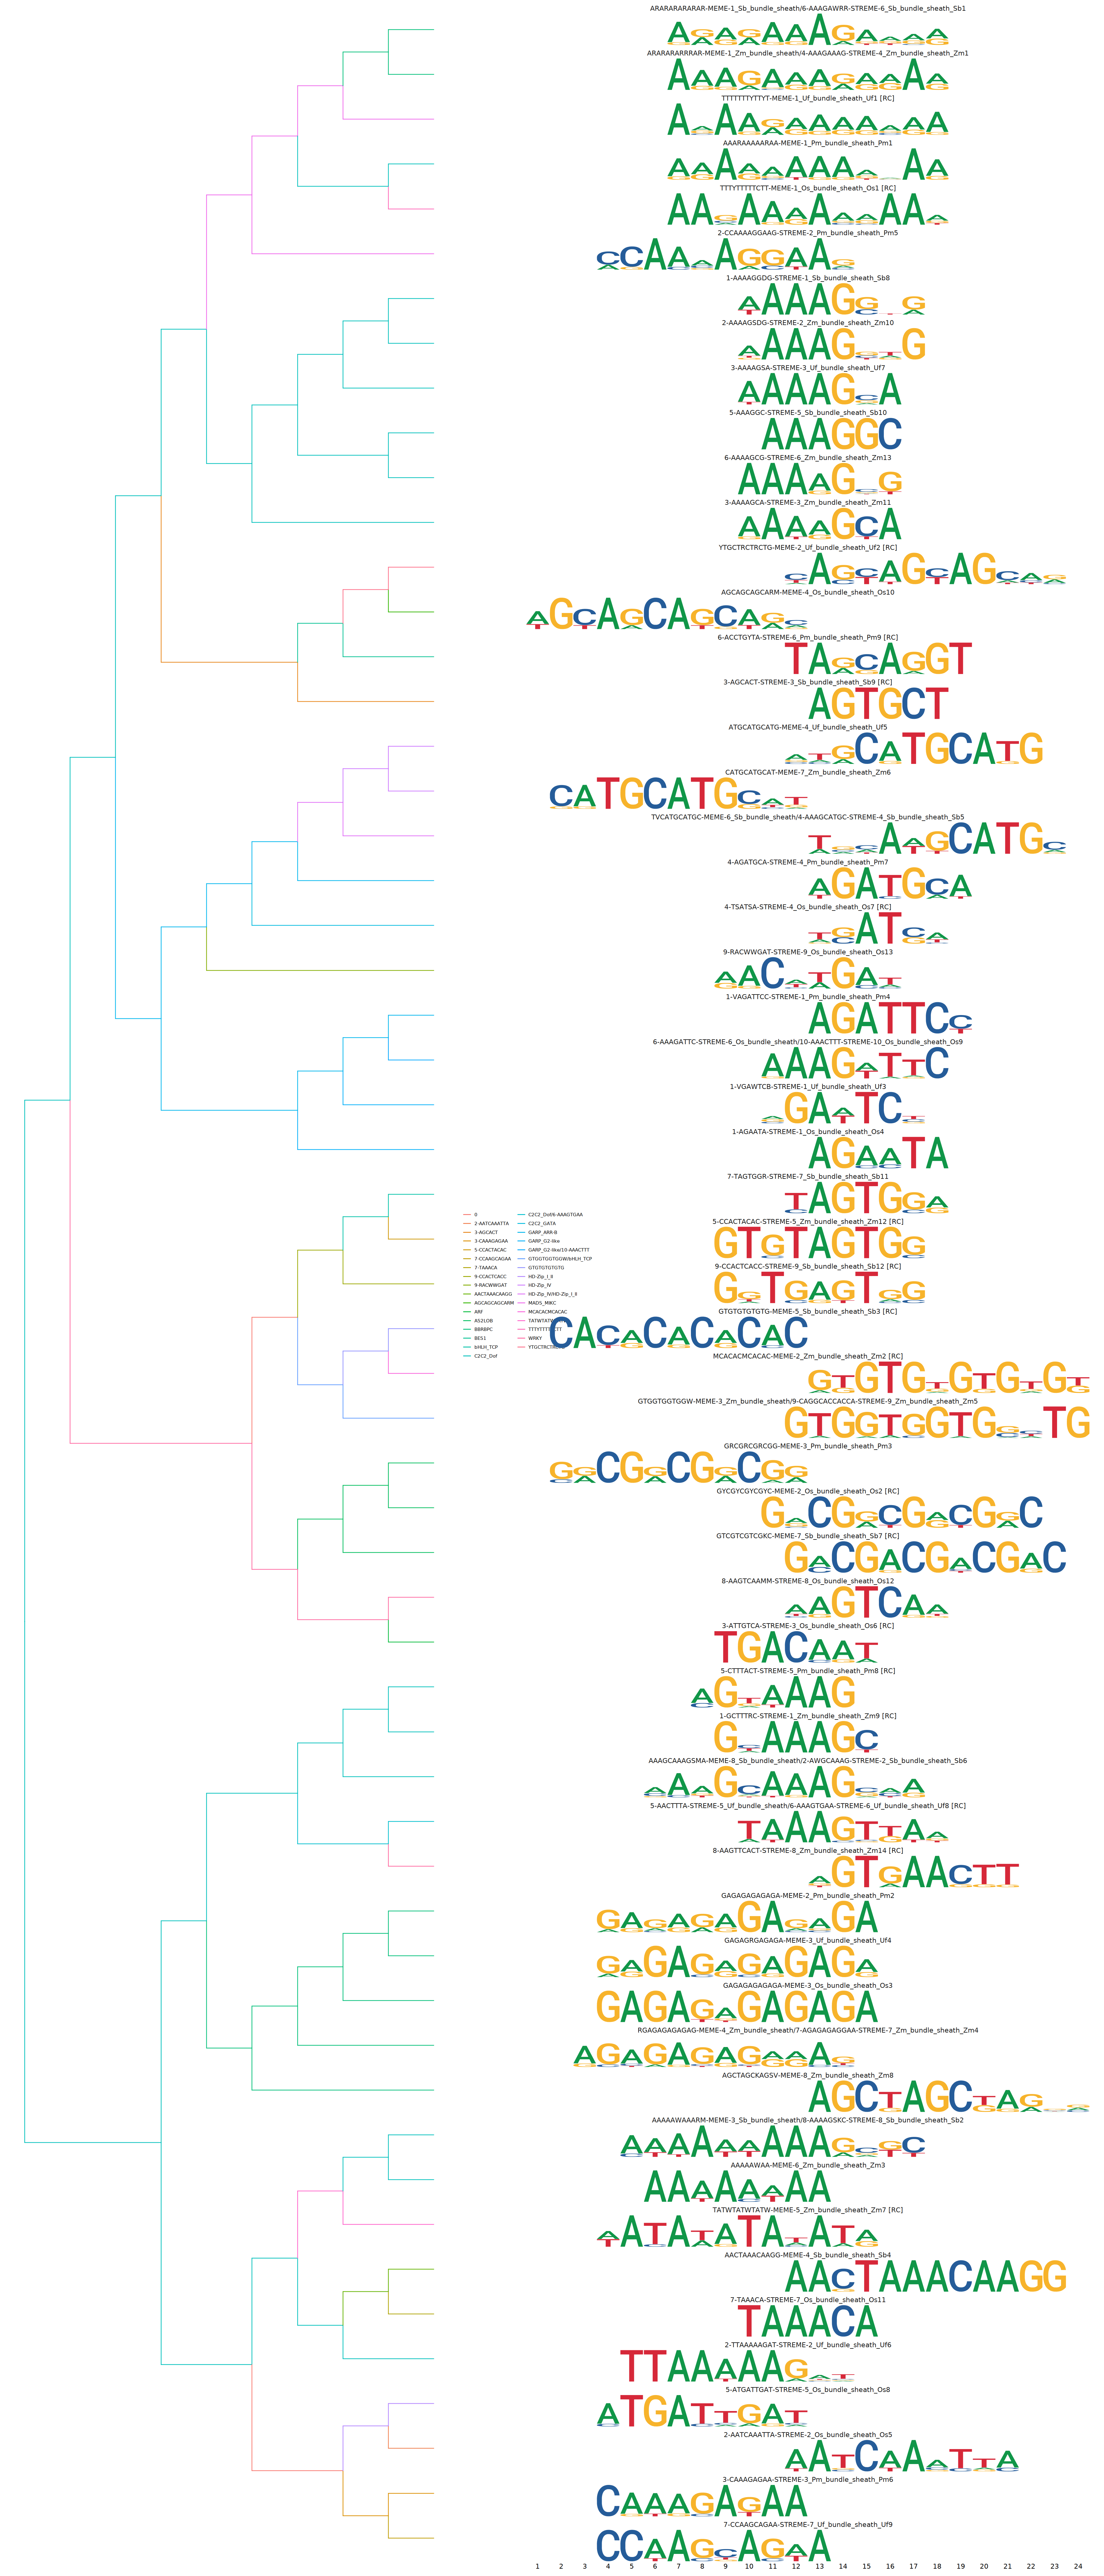

In [14]:
bs_all_filtered_motifs <- lapply(bs_all_filtered_motifs, process_motif_sublist)
bs_merged_list <- unlist(bs_all_filtered_motifs, recursive = FALSE)
bs_merged_list <- update_motif_altname(bs_merged_list)



bs_filtered_motifs <- lapply(bs_merged_list, function(motif) {
  motif <- trim_motifs(motif)
  motif <- round_motif(motif)
  motif@name <- motif@altname
  return(motif)
})


umap_cluster_colors <- c("#DEA940","#A2A763","#D6EEBE","#5894D4","#6AAD51","#6C8686","#FFD92F", "#7f2201","#b53310",
                         "#E7673B","#FB9A99","#E31A1C","#FDBF6F","#CAB2D6","#386CB0","#FFFFB3", "#5dead5","#c11577",
                         "#CCCCCC", "#7570B3","#B15928", "#6A3D9A", "#d87c6a", "#0060e8", "#84c5ff", "#ffd460", "#d81397")


# Generate the motif tree
tree_bs <- motif_tree(bs_filtered_motifs, method = "HELL",  tryRC = TRUE,
                      layout = "rectangular", linecol = "family")

# Extract the order based on the tree
bs_new.order <- tree_bs$data$label[tree_bs$data$isTip]
bs_new.order <- rev(bs_new.order[order(tree_bs$data$y[tree_bs$data$isTip])])


# Extract names or altname from filtered_motifs
bs_motif_names <- sapply(bs_filtered_motifs, function(x) x@name)

# Match the names with the new_order
bs_order_index <- match(bs_new.order, bs_motif_names)

# Reorder filtered_motifs based on the matched index
bs_reordered_motifs <- bs_filtered_motifs[bs_order_index]


#filtered_motifs <- filtered_motifs[new.order]

options(repr.plot.width=30, repr.plot.height=70)
# Plot the motifs and the tree side by side
bs_specific_tree <- plot_grid(nrow = 1, rel_widths = c(1, -0.15, 1),
          tree_bs + xlab(""), NULL,
          view_motifs(bs_reordered_motifs <- bs_filtered_motifs[bs_order_index]) +
            ylab(element_blank()) +
            theme(
              axis.line.y = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.y = element_blank(),
              axis.text = element_text(colour = "white")
            )
)
                         
bs_specific_tree

In [16]:
## Save trees
ggsave(filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_6/trees/Ms.vs.Bs.specific_trees.pdf", 
       plot = ms_specific_tree, device = "pdf", width = 35, height = 70, limitsize = FALSE)


ggsave(filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_6/trees/Bs.vs.Msspecific_trees.pdf", 
       plot = bs_specific_tree, device = "pdf", width = 35, height = 70, limitsize = FALSE)


### Merging Motifs for Downstream Analysis

In [156]:
?merge_motifs

merge_motifs          package:universalmotif           R Documentation

_M_e_r_g_e _m_o_t_i_f_s.

_D_e_s_c_r_i_p_t_i_o_n:

     Aligns the motifs using ‘compare_motifs()’, then averages the
     motif PPMs. Currently the ‘multifreq’ slot, if filled in any of
     the motifs, will be dropped. Only 0-order background probabilities
     will be kept. Motifs are merged one at a time, starting with the
     first entry in the list.

_U_s_a_g_e:

     merge_motifs(motifs, method = "ALLR", use.type = "PPM", min.overlap = 6,
       min.mean.ic = 0.25, tryRC = TRUE, relative_entropy = FALSE,
       normalise.scores = FALSE, min.position.ic = 0, score.strat = "sum",
       new.name = NULL)
     
_A_r_g_u_m_e_n_t_s:

  motifs: See ‘convert_motifs()’ for acceptable motif formats.

  method: ‘character(1)’ One of PCC, EUCL, SW, KL, ALLR, BHAT, HELL,
          SEUCL, MAN, ALLR_LL, WEUCL, WPCC. See details.

use.type: ‘character(1)’ One of ‘'PPM'’ and ‘'ICM'’. The latter allows
          for taking into account the background frequencies if
          ‘relative_entropy = TRUE’. Note that ‘'ICM'’ is not allowed
          when ‘method = c("ALLR", "ALLR_LL")’.

min.overlap: ‘numeric(1)’ Minimum overlap required when aligning the
          motifs. Setting this to a number higher then the width of the
          motifs will not allow any overhangs. Can also be a number
          between 0 and 1, representing the minimum fraction that the
          motifs must overlap.

min.mean.ic: ‘numeric(1)’ Minimum mean information content between the
          two motifs for an alignment to be scored. This helps prevent
          scoring alignments between low information content regions of
          two motifs. Note that this can result in some comparisons
          failing if no alignment passes the mean IC threshold. Use
          ‘average_ic()’ to filter out low IC motifs to get around this
          if you want to avoid getting ‘NA’s in your output.

   tryRC: ‘logical(1)’ Try the reverse complement of the motifs as
          well, report the best score.

relative_entropy: ‘logical(1)’ Change the ICM calculation affecting
          ‘min.position.ic’ and ‘min.mean.ic’. See ‘convert_type()’.

normalise.scores: ‘logical(1)’ Favour alignments which leave fewer
          unaligned positions, as well as alignments between motifs of
          similar length. Similarity scores are multiplied by the ratio
          of aligned positions to the total number of positions in the
          larger motif, and the inverse for distance scores.

min.position.ic: ‘numeric(1)’ Minimum information content required
          between individual alignment positions for it to be counted
          in the final alignment score. It is recommended to use this
          together with ‘normalise.scores = TRUE’, as this will help
          punish scores resulting from only a fraction of an alignment.

score.strat: ‘character(1)’ How to handle column scores calculated from
          motif alignments. "sum": add up all scores. "a.mean": take
          the arithmetic mean. "g.mean": take the geometric mean.
          "median": take the median. "wa.mean", "wg.mean": weighted
          arithmetic/geometric mean. "fzt": Fisher Z-transform. Weights
          are the total information content shared between aligned
          columns.

new.name: ‘character(1)’, ‘NULL’ Instead of collapsing existing names
          (if ‘NULL’), assign a new one manually for the merged motif.

_D_e_t_a_i_l_s:

     See ‘compare_motifs()’ for more info on comparison parameters.

     If using a comparison metric where 0s are not allowed (‘KL’,
     ‘ALLR’, ‘ALLR_LL’, ‘IS’), then pseudocounts will be added
     internally. These pseudocounts are only used for comparison and
     alignment, and are not used in the final merging step.

     Note: ‘score.strat = "a.mean"’ is NOT recommended, as
     ‘merge_motifs()’ will not discriminate between two alignments with
     equal m

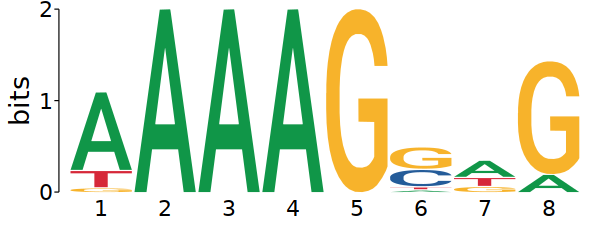

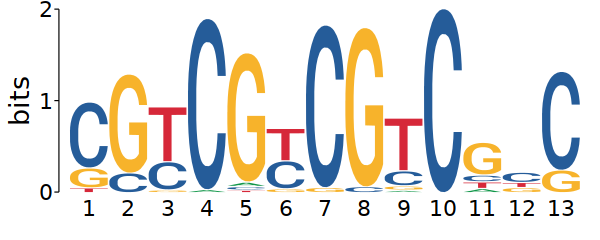

In [162]:
bs_merged_dof_motif <- merge_motifs(list(bs_reordered_motifs$Sb8, 
                                         bs_reordered_motifs$Zm10, 
                                         bs_reordered_motifs$Uf7),
                                                            min.mean.ic = 1.2,
                        normalise.scores = TRUE,
                        min.position.ic = 1,
                        tryRC = TRUE)

view_motifs(trim_motifs(bs_merged_dof_motif, min.ic = 0.5))

bs_GTGGT <- merge_motifs(list(bs_reordered_motifs$Sb8, 
                                         bs_reordered_motifs$Zm10, 
                                         bs_reordered_motifs$Uf7),
                                                            min.mean.ic = 1.2,
                        normalise.scores = TRUE,
                        min.position.ic = 1,
                        tryRC = TRUE)


# bs_merged_CATG_motif <- merge_motifs(list(bs_reordered_motifs$Sb11, bs_reordered_motifs$Zm6, bs_reordered_motifs$Pm9, bs_reordered_motifs$Uf4),
#                                                              min.mean.ic = 1.2,
#                         normalise.scores = TRUE,
#                         min.position.ic = 1,
#                         tryRC = TRUE)



# bs_GCCGCC <- merge_motifs(list(bs_reordered_motifs$Zm17, bs_reordered_motifs$Pm13, bs_reordered_motifs$Uf11, bs_reordered_motifs$Sb13),
#                        min.mean.ic = 1.2,
#                         normalise.scores = TRUE,
#                         min.position.ic = 1,
#                         tryRC = TRUE)





ms_CGTCGTCGT <- merge_motifs(list(reordered_motifs$Pm1, reordered_motifs$Zm1, reordered_motifs$Sb1, reordered_motifs$Os10, reordered_motifs$Uf2), 
                         min.mean.ic = 1.2,
                        normalise.scores = TRUE,
                        min.position.ic = 1,
                        tryRC = TRUE)

# options(repr.plot.width=5, repr.plot.height=2)
view_motifs(trim_motifs(ms_CGTCGTCGT, min.ic = 0.5))



# ms_CGCCGC <- trim_motifs(merge_motifs(list(reordered_motifs$Sb7, reordered_motifs$Os9, reordered_motifs$Pm6, reordered_motifs$Uf9), 
#                          min.mean.ic = 1.2,
#                         normalise.scores = TRUE,
#                         min.position.ic = 1,
#                         tryRC = TRUE))
# options(repr.plot.width=5, repr.plot.height=2)

# options(repr.plot.width=5, repr.plot.height=8)

# view_motifs(list(reordered_motifs$Sb7, reordered_motifs$Os9, reordered_motifs$Pm6, reordered_motifs$Uf9))
# options(repr.plot.width=5, repr.plot.height=2)
# view_motifs(trim_motifs(ms_CGCCGC, min.ic = 0.5))




# finalized_list <- list(bs_merged_dof_motif, bs_merged_CATG_motif, bs_GCCGCC,  ms_AGCTA, ms_GACA)




# motif_view <- view_motifs(finalized_list)

# # motif_view
# # ggsave(filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_6/merged_motifs.pdf", 
# #        plot = motif_view, device = "pdf", width = 10, height = 20)


In [164]:
ms_CGTCGTCGT <- merge_motifs(list(reordered_motifs$Pm1, reordered_motifs$Zm1, reordered_motifs$Sb1, reordered_motifs$Os10, reordered_motifs$Uf2), 
                         min.mean.ic = 1.2,
                        normalise.scores = TRUE,
                        min.position.ic = 1,
                        tryRC = TRUE, new.name = "ms_CGTCGTCGT")

ms_CGTCGTCGT


       Motif name:   ms_CGTCGTCGT
   Alternate name:   CGYCGYCGYCG-MEME-2_Pm_mesophyll_Pm1/CGYC...
           Family:   AS2LOB/AS2LOB/2-ACGACGASV/ARF
         Organism:   Pm/Zm/Sb/Os/Uf
         Alphabet:   DNA
             Type:   PPM
          Strands:   +-
         Total IC:   15.73
      Pseudocount:   1
        Consensus:   CGYCGYCGTCGNC
     Target sites:   1865
          E-value:   0.81
       Extra info:   [eval.string] 4.0e-026 
                     [eval.string] 1.0e-019
                     [eval.string] 1.8e-025
                     ...

     C    G    Y    C    G    Y    C    G    T C    G    N    C
A 0.00 0.00 0.00 0.01 0.03 0.01 0.00 0.00 0.03 0 0.07 0.08 0.00
C 0.73 0.16 0.33 0.99 0.03 0.44 0.97 0.03 0.21 1 0.14 0.46 0.82
G 0.22 0.83 0.03 0.00 0.93 0.05 0.03 0.97 0.06 0 0.65 0.22 0.18
T 0.05 0.01 0.64 0.00 0.01 0.50 0.00 0.00 0.71 0 0.14 0.24 0.00

In [165]:
write_meme(ms_CGTCGTCGT, file = "/home/jpm73279/genome_downloads/C4_markers/found_motifs/Ms.specific_CGTCGT_motif.comparative.meme",
           overwrite = TRUE)

# DEPRECTAED Fine Tuning Tree Building

[1] "Pair: TTYTTTTTYTT-MEME-2_Os_bundle_sheath_Os2 - 1-CGCGCGCGCGSSSSS-STREME-1_Os_bundle_sheath_Os9 with correlation 0.726209339667717"
[1] "Pair: CGCCGYCGYCGYCGC-MEME-1_Os_bundle_sheath_Os1 - 3-AGATTCC-STREME-3_Os_bundle_sheath_Os11 with correlation 0.658034229258787"
[1] "Pair: CYCTCYCTCYCYCYC-MEME-3_Os_bundle_sheath_Os3 - 3-AGATTCC-STREME-3_Os_bundle_sheath_Os11 with correlation 0.667728577656152"
[1] "Pair: GCGSGCGCGCGCSGC-MEME-4_Os_bundle_sheath_Os5 - 3-AGATTCC-STREME-3_Os_bundle_sheath_Os11 with correlation 0.664486691074601"
[1] "Pair: 1-CGCGCGCGCGSSSSS-STREME-1_Os_bundle_sheath_Os9 - 3-AGATTCC-STREME-3_Os_bundle_sheath_Os11 with correlation 0.719023556860375"
[1] "Pair: TTYTTTTTYTT-MEME-2_Os_bundle_sheath_Os2 - 4-CGCGNCGCG-STREME-4_Os_bundle_sheath_Os12 with correlation 0.714478390209562"
[1] "Pair: 3-AGATTCC-STREME-3_Os_bundle_sheath_Os11 - 4-CGCGNCGCG-STREME-4_Os_bundle_sheath_Os12 with correlation 0.684097567712994"
[1] "Pair: TTYTTTTTYTT-MEME-2_Os_bundle_sheath_Os2 - 7-CCC

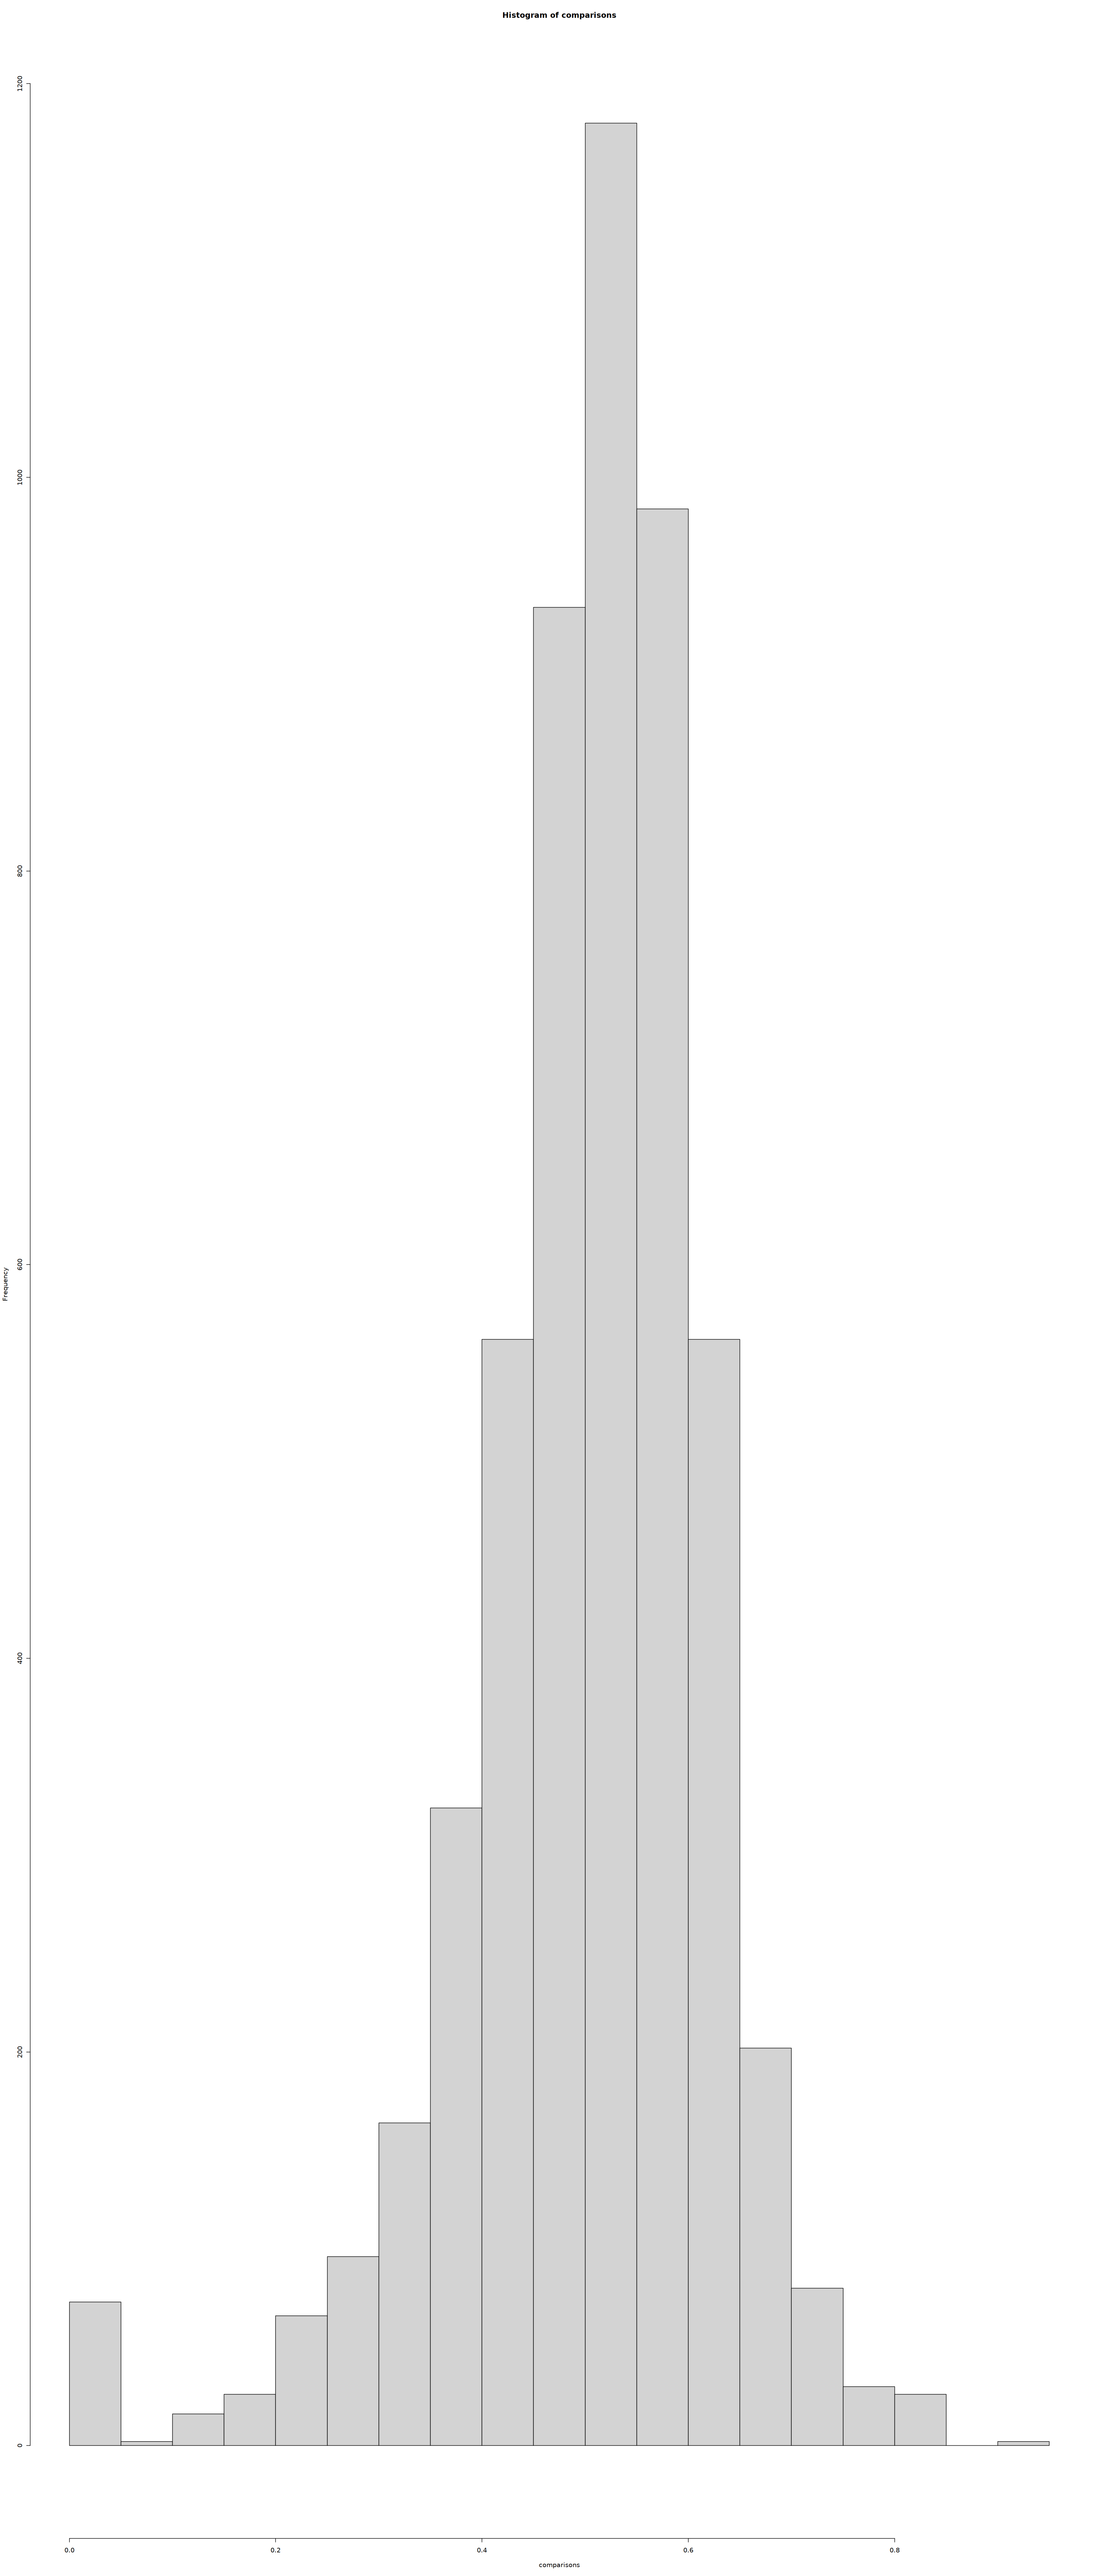

In [103]:

## Step 1: compare motifs
comparisons <- compare_motifs(bs_filtered_motifs, method = "HELL", min.mean.ic = 0, score.strat = "a.mean")

hist(comparisons)
# The current metric, PCC, is a similarity metric
#comparisons <- 1 - comparisons
#comparisons <- as.dist(comparisons)

# Assuming cor_matrix is your correlation matrix
threshold = 0.65


cor_matrix <- comparisons 
# Find indices of elements greater than the threshold
high_corr_indices = which(cor_matrix > threshold, arr.ind = TRUE)

# Filter out diagonal elements and redundant pairs
high_corr_pairs = high_corr_indices[high_corr_indices[, 1] < high_corr_indices[, 2], ]

# Extract pairs
for (i in 1:nrow(high_corr_pairs)) {
  row = high_corr_pairs[i, 1]
  col = high_corr_pairs[i, 2]
  print(paste("Pair:", rownames(cor_matrix)[row], "-", colnames(cor_matrix)[col], 
              "with correlation", cor_matrix[row, col]))
}





In [21]:
comparisons

In [27]:
most_similar_motifs <- list()

# Iterate over the filtered similar pairs
for (i in 1:nrow(similar_pairs_filtered)) {
    row = similar_pairs_filtered[i, 1]
    col = similar_pairs_filtered[i, 2]
    
    # Add the pair to the list along with its Hellinger distance
    most_similar_motifs[[i]] <- list(
        pair = c(row, col),
        distance = distance_matrix[row, col]
    )
}


In [ ]:


# Generate the motif tree
tree_bs <- motif_tree(bs_filtered_motifs, method = "HELL",  tryRC = TRUE,
                      layout = "rectangular", linecol = "family")

# Extract the order based on the tree
bs_new.order <- tree_bs$data$label[tree_bs$data$isTip]
bs_new.order <- rev(bs_new.order[order(tree_bs$data$y[tree_bs$data$isTip])])


# Extract names or altname from filtered_motifs
bs_motif_names <- sapply(bs_filtered_motifs, function(x) x@name)

# Match the names with the new_order
bs_order_index <- match(bs_new.order, bs_motif_names)

# Reorder filtered_motifs based on the matched index
bs_reordered_motifs <- bs_filtered_motifs[bs_order_index]


#filtered_motifs <- filtered_motifs[new.order]

options(repr.plot.width=20, repr.plot.height=60)

# Plot the motifs and the tree side by side
plot_grid(nrow = 1, rel_widths = c(1, -0.15, 1),
          tree_bs + xlab(""), NULL,
          view_motifs(bs_reordered_motifs <- bs_filtered_motifs[bs_order_index]
, names.pos = "right") +
            ylab(element_blank()) +
            theme(
              axis.line.y = element_blank(),
              axis.ticks.y = element_blank(),
              axis.text.y = element_blank(),
              axis.text = element_text(colour = "white")
            )
)

In [20]:
glimpse(comparisons)

In [ ]:
# We also want to extract names from the dist object to match annotations
labels <- attr(comparisons, "Labels")

In [ ]:
## Step 3: get the comparisons ready for tree-building
# The R package "ape" provides the necessary "as.phylo" function
comparison_fixed <- ape::as.phylo(hclust(comparisons))

In [ ]:
# Your cutree output
test <- cutree(hclust(comparisons), k = 8)

# Initialize a list to store the motifs for each cluster
clustered_motifs <- vector("list", length = max(test))
names(clustered_motifs) <- paste0("Cluster", 1:max(test))

# Iterate over each cluster
for (cluster in 1:max(test)) {
  # Find the names of motifs that belong to this cluster
  motif_names_in_cluster <- names(test)[test == cluster]

  # Match these names with the names in your motif_list
  index_in_motif_list <- sapply(bs_filtered_motifs, function(motif) motif@name %in% motif_names_in_cluster)

  # Extract the motifs that belong to this cluster
  clustered_motifs[[cluster]] <- bs_filtered_motifs[index_in_motif_list]
}

In [ ]:
process_and_plot_cluster <- function(motifs) {
  # Check if the list of motifs is empty
  if (length(motifs) == 0) {
    cat("No motifs found in this cluster.\n")
    return(NULL)
  }

  # Generate the motif tree
  tree_bs <- motif_tree(motifs, method = "HELL", layout = "rectangular", linecol = "family")

  # Extract the order based on the tree
  bs_new.order <- tree_bs$data$label[tree_bs$data$isTip]
  bs_new.order <- rev(bs_new.order[order(tree_bs$data$y[tree_bs$data$isTip])])

  # Extract names or altname from filtered_motifs
  bs_motif_names <- sapply(motifs, function(x) x@name)

  # Match the names with the new_order
  bs_order_index <- match(bs_new.order, bs_motif_names)

  # Reorder filtered_motifs based on the matched index
  bs_reordered_motifs <- motifs[bs_order_index]

  # Plot the motifs and the tree side by side
  plot_grid(nrow = 1, rel_widths = c(1, -0.15, 1),
            tree_bs + xlab(""), NULL,
            view_motifs(bs_reordered_motifs, names.pos = "right") +
              ylab(element_blank()) +
              theme(
                axis.line.y = element_blank(),
                axis.ticks.y = element_blank(),
                axis.text.y = element_blank(),
                axis.text = element_text(colour = "white")
              )
  )
}

options(repr.plot.width=20, repr.plot.height=20)
# Apply the function to each cluster
lapply(clustered_motifs, process_and_plot_cluster)
